# Relhum_water and its helper function _relhum_water from meteorology.py
This function just accepts NumPy array, list, and float inputs. So, there is no need to port for xarray and dask array; however, it also works with xarray without dask (tested).

In [1]:
import time
import unittest
from test.test_meteorology import Test_relhum_water

import cupy as cp
import dask
import numpy as npx
import pandas as pd
import xarray as xr
import src.geocat.comp.meteorology as geo
csvpath = "relhum_water_ported_test_numpy.csv"

## Plotting and Validation

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot(allData,name):
    arraysizes = np.unique(allData['ArraySize'])
    sd_numpy = np.zeros(len(arraysizes))
    sd_cupy = np.zeros(len(arraysizes))
    y_numpy = np.zeros(len(arraysizes))
    y_cupy = np.zeros(len(arraysizes))
    plt.rcParams.update({'font.size': 20})
    for i in range(0,len(arraysizes)):
        cupydata = allData.loc[(allData['ArraySize'] == arraysizes[i]) & (allData['Approach'] == 'cupy')]
        numpydata = allData.loc[(allData['ArraySize'] == arraysizes[i]) & (allData['Approach'] == 'numpy')]
        y_cupy[i] = np.mean(cupydata['Runtime(s)'])
        y_numpy[i] = np.mean(numpydata['Runtime(s)'])
        sd_cupy[i] = np.std(cupydata['Runtime(s)'])
        sd_numpy[i] = np.std(numpydata['Runtime(s)'])
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.errorbar(arraysizes, y_numpy, yerr=sd_numpy, fmt='-o',label='numpy')
    ax.errorbar(arraysizes, y_cupy, yerr=sd_cupy, fmt='-o',label='cupy')
    ax.legend();  # Add a legend.
    ax.set_xlabel('ArraySize')  # Add an x-label to the axes.
    ax.set_ylabel('Runtime(s)')  # Add a y-label to the axes.
    ax.set_title(("Test_relhum_water"))
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.savefig(name,dpi=fig.dpi)
    
def test_validation(res_numpy,res_cupy):
    assert np.allclose(res_numpy,res_cupy, atol=0.0000001)

## Initializing Arrays

In [3]:
max_power = 8
chunksize = 10**5
p_def_arrays = []
t_def_arrays = []
q_def_arrays = []
for i in range(1,max_power):
    ArraySize = 10**i
    p_def_arrays.append(np.random.uniform(low=2000,high=100800,size=10**i))
    t_def_arrays.append(np.random.uniform(low=194.65,high=302.45,size=10**i))
    q_def_arrays.append(np.random.uniform(low=0,high=0.02038,size=10**i))
numpy_results = []
cupy_results = []

## Testing Numpy input and CPU

In [4]:
xp = np
for i in range(max_power):
    p_def = p_def_arrays[i-1]
    q_def = q_def_arrays[i-1]
    t_def = t_def_arrays[i-1]
    rh_gt_1 = geo.relhum_water(t_def, q_def, p_def, use_gpu = False)

In [5]:
type(rh_gt_1)

numpy.ndarray

## Testing Numpy input and GPU

In [6]:
for i in range(max_power):
    p_def = p_def_arrays[i-1]
    q_def = q_def_arrays[i-1]
    t_def = t_def_arrays[i-1]
    rh_gt_2 = geo.relhum_water(t_def, q_def, p_def, use_gpu = True)

In [7]:
type(rh_gt_2)

cupy._core.core.ndarray

## Testing Xarray input and CPU

In [8]:
import xarray as xr
for i in range(max_power):
    p_def = p_def_arrays[i-1]
    q_def = q_def_arrays[i-1]
    t_def = t_def_arrays[i-1]
    p = xr.DataArray(p_def)
    q = xr.DataArray(q_def)
    t = xr.DataArray(t_def)
    rh_gt_1 = geo.relhum_water(t, q, p, use_gpu = False).compute()

In [9]:
type(rh_gt_1.data)

numpy.ndarray

## Testing Xarray input and GPU

In [10]:
for i in range(2):
    p_def = p_def_arrays[i-1]
    q_def = q_def_arrays[i-1]
    t_def = t_def_arrays[i-1]
    p = xr.DataArray(p_def)
    q = xr.DataArray(q_def)
    t = xr.DataArray(t_def)
    rh_gt_2 = geo.relhum_water(t, q, p, use_gpu = True).compute()

In [11]:
rh_gt_2.data.device

<CUDA Device 0>

## Unittests with CPU!

In [2]:
test = Test_relhum_water()

test.test_float_input(use_gpu = False)

## Unittests with GPU

In [3]:
test = Test_relhum_water()

test.test_float_input(use_gpu = True)

## Benchmark Results for different Array Sizes (NUMPY/CUPY)

In [14]:
#Test_relhum main body
Routine = "Relhum_water"
print(Routine)
allData = pd.DataFrame()
#For different Array sizes
for i in range(1,max_power):
    ArraySize = 10**i
    p_def = p_def_arrays[i-1].data
    t_def = t_def_arrays[i-1].data
    q_def = q_def_arrays[i-1].data
    print("Array size: ", ArraySize)
    #for numpy and cupy both
    for xp in [np,cp]:
        #calculation will be repeated 10 time to get the less biased performance results
        repsize = 10
        repeat = np.zeros([repsize])
        for rep in range(0,repsize):
            #create different sizes of arrays
            if(xp == cp):
                res_cupy = geo.relhum_water(t_def, q_def, p_def,True)
                cp.cuda.runtime.deviceSynchronize()
                time1 = time.time()
                res_cupy = geo.relhum_water(t_def, q_def, p_def,True)
                cp.cuda.runtime.deviceSynchronize()
                time2 = time.time()
                repeat[rep] = time2-time1
            else:
                res_numpy = geo.relhum_water(t_def, q_def,p_def,False)
                time1 = time.time()
                res_numpy = geo.relhum_water(t_def, q_def,p_def,False)
                time2 = time.time()
                repeat[rep] = time2-time1
        #save times
        data = {'Routine': np.repeat(Routine, repsize),
                'Input':"NumPy input",
                'Approach': np.repeat(xp.__name__ , repsize),
                'ArraySize': np.repeat(ArraySize , repsize),
                'iteration' : np.arange(1,repsize+1),
                'Runtime(s)': repeat}

        allData = pd.concat([allData,pd.DataFrame(data)], ignore_index=True)
        print(xp.__name__,np.mean(repeat), "seconds")
    test_validation(res_numpy,res_cupy)
try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)

Relhum_water
Array size:  10
numpy 1.3899803161621093e-05 seconds
cupy 0.0002652645111083984 seconds
Array size:  100
numpy 1.8143653869628905e-05 seconds
cupy 0.00026009082794189455 seconds
Array size:  1000
numpy 2.1958351135253905e-05 seconds
cupy 0.00026884078979492185 seconds
Array size:  10000
numpy 6.625652313232421e-05 seconds
cupy 0.0003139734268188477 seconds
Array size:  100000
numpy 0.0008736133575439453 seconds
cupy 0.0007911443710327149 seconds
Array size:  1000000
numpy 0.013472461700439453 seconds
cupy 0.005812168121337891 seconds
Array size:  10000000
numpy 0.2474372386932373 seconds
cupy 0.056971073150634766 seconds


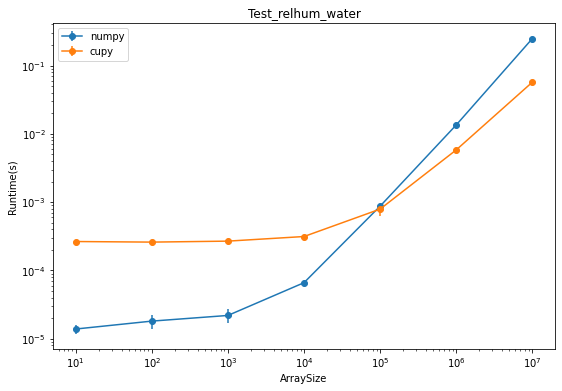

In [15]:
plot(allData,"Test_relhum_water_ported_numpy.jpg")

## Results for different ArraySizes Xarray (with NumPy/CuPy arrays inside the Xarray)

### Test Relhum on CPU

In [16]:
csvpath = "relhum_water_ported_test_xarray.csv"
#Test_relhum main body
Routine = "Relhum"
print(Routine)
allData = pd.DataFrame()
#For different Array sizes
for i in range(1,max_power):
    ArraySize = 10**i
    print("Array size: ", ArraySize)
    p_def = p_def_arrays[i-1].data
    t_def = t_def_arrays[i-1].data
    q_def = q_def_arrays[i-1].data
    #for numpy and cupy both
    xp = np 
    repsize = 10
    repeat = np.zeros([repsize])
    for rep in range(0,repsize):
    #create different sizes of arrays
        numpy_res = geo.relhum_water(t_def, q_def, p_def,False)
        time1 = time.time()
        numpy_res = geo.relhum_water(t_def, q_def, p_def,False)
        time2 = time.time()
        repeat[rep] = time2-time1
    numpy_results.append(numpy_res)
    #save times
    data = {'Routine': np.repeat(Routine, repsize),
            'Input':"Xarray with NumPy input",
            'Approach': np.repeat(xp.__name__ , repsize),
            'ArraySize': np.repeat(ArraySize , repsize),
            'iteration' : np.arange(1,repsize+1),
            'Runtime(s)': repeat}
    allData = pd.concat([allData,pd.DataFrame(data)], ignore_index=True)
    print(xp.__name__,np.mean(repeat), "seconds")
try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)

Relhum
Array size:  10
numpy 1.392364501953125e-05 seconds
Array size:  100
numpy 1.3279914855957032e-05 seconds
Array size:  1000
numpy 2.067089080810547e-05 seconds
Array size:  10000
numpy 7.26938247680664e-05 seconds
Array size:  100000
numpy 0.0010889053344726562 seconds
Array size:  1000000
numpy 0.013346338272094726 seconds
Array size:  10000000
numpy 0.250799298286438 seconds


### Test Relhum on GPU

Relhum
Array size:  10
cupy 0.0002548694610595703 seconds
Array size:  100
cupy 0.00026783943176269533 seconds
Array size:  1000
cupy 0.0002643823623657227 seconds
Array size:  10000
cupy 0.00031979084014892577 seconds
Array size:  100000
cupy 0.0007579326629638672 seconds
Array size:  1000000
cupy 0.007252264022827149 seconds
Array size:  10000000
cupy 0.057566714286804196 seconds


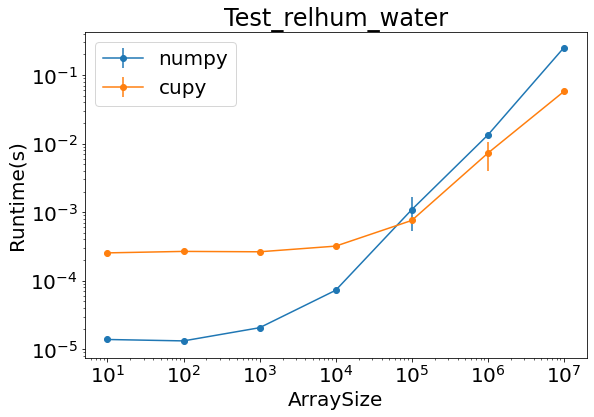

In [17]:
#Test_relhum main body
Routine = "Relhum"
print(Routine)
#For different Array sizes
for i in range(1,max_power):
    ArraySize = 10**i
    p_def = p_def_arrays[i-1].data
    t_def = t_def_arrays[i-1].data
    q_def = q_def_arrays[i-1].data
    print("Array size: ", ArraySize)
    #for numpy and cupy both
    xp = cp
        #calculation will be repeated 10 time to get the less biased performance results
    repsize = 10
    repeat = np.zeros([repsize])
    for rep in range(0,repsize):
        #create different sizes of arrays
        cupy_res = geo.relhum_water(t_def, q_def, p_def,True)
        cp.cuda.runtime.deviceSynchronize()
        time1 = time.time()
        cupy_res = geo.relhum_water(t_def, q_def, p_def,True)
        cp.cuda.runtime.deviceSynchronize()
        time2 = time.time()
        repeat[rep] = time2-time1
    cupy_results.append(cupy_res)
    #save times
    data = {'Routine': np.repeat(Routine, repsize),
            'Input':"Xarray with NumPy input",
            'Approach': np.repeat(xp.__name__ , repsize),
            'ArraySize': np.repeat(ArraySize , repsize),
            'iteration' : np.arange(1,repsize+1),
            'Runtime(s)': repeat}
    allData = pd.concat([allData,pd.DataFrame(data)], ignore_index=True)
    print(xp.__name__,np.mean(repeat), "seconds")

try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)
plot(allData,"Test_relhum_water_ported_xarray.jpg")

### Validation

In [18]:
#validation 
for i in range(len(numpy_results)):
    test_validation(cupy_results[i],numpy_results[i])

In [19]:
cupy_results[0]

array([1.84962963e+01, 2.90282159e+01, 1.98038071e+02, 1.04862446e+02,
       6.98535971e+01, 2.56274122e+01, 3.97830575e+01, 6.26482899e+04,
       1.72508368e+03, 5.65835897e+02])

In [20]:
numpy_results[0]

array([1.84962963e+01, 2.90282159e+01, 1.98038071e+02, 1.04862446e+02,
       6.98535971e+01, 2.56274122e+01, 3.97830575e+01, 6.26482899e+04,
       1.72508368e+03, 5.65835897e+02])